In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("kaggle_dataset\mobilePrice\mobilePrice.csv", sep=",")

df.head()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\bhc02\AppData\Local\Temp\ipykernel_6292\3300775601.py:9: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("kaggle_dataset\mobilePrice\mobilePrice.csv", sep=",")


,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [71]:
#1. 미사용 컬럼 제거
df = df.drop(columns=['id', 'm_dep'])

In [72]:
#2. 결측치 처리
df['px_height'] = df['px_height'].replace(0, np.nan)
df['px_width'] = df['px_width'].replace(0, np.nan)
df['sc_h'] = df['sc_h'].replace(0, np.nan)
df['sc_w'] = df['sc_w'].replace(0, np.nan)

df['px_height'] = df['px_height'].fillna(df['px_height'].mean())
df['sc_w'] = df['sc_w'].fillna(df['sc_w'].mean())
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
dtype: int64

In [73]:
#3. 이상치 처리


In [74]:
#4. Feature Engineering
battery = df['talk_time'] / df['battery_power']
df['battery'] = battery * 100

camera = (df['fc'] + df['pc']) / 2
df['camera'] = camera

pixel = df['px_height'] * df['px_width']
display_size = (df['sc_h'] + df['sc_w']) * 10000
df['display'] = display_size / pixel

#정규화 이후 시각화 결과 display가 왼쪽으로 극단적으로 치우쳐짐
#-> 로그로 변환해 한쪽으로 쏠린걸 완화
df['display'] = np.log1p(df['display'])
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,mobile_wt,n_cores,pc,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,battery,camera,display
0,1043,1,1.8,1,14,0,5,193,3,16,...,3476,12,7.000000,2,0,1,0,0.191755,15.0,0.467126
1,841,1,0.5,1,4,1,61,191,5,12,...,3895,6,5.986486,7,1,0,0,0.832342,8.0,0.171840
2,1807,1,2.8,0,1,0,27,186,3,4,...,2396,17,10.000000,10,0,1,1,0.553403,2.5,0.144651
3,1546,0,0.5,1,18,1,25,96,8,20,...,3893,10,5.986486,7,1,1,0,0.452781,19.0,0.269502
4,1434,0,1.4,0,11,1,49,108,6,18,...,1773,15,8.000000,7,1,0,1,0.488145,14.5,0.321436


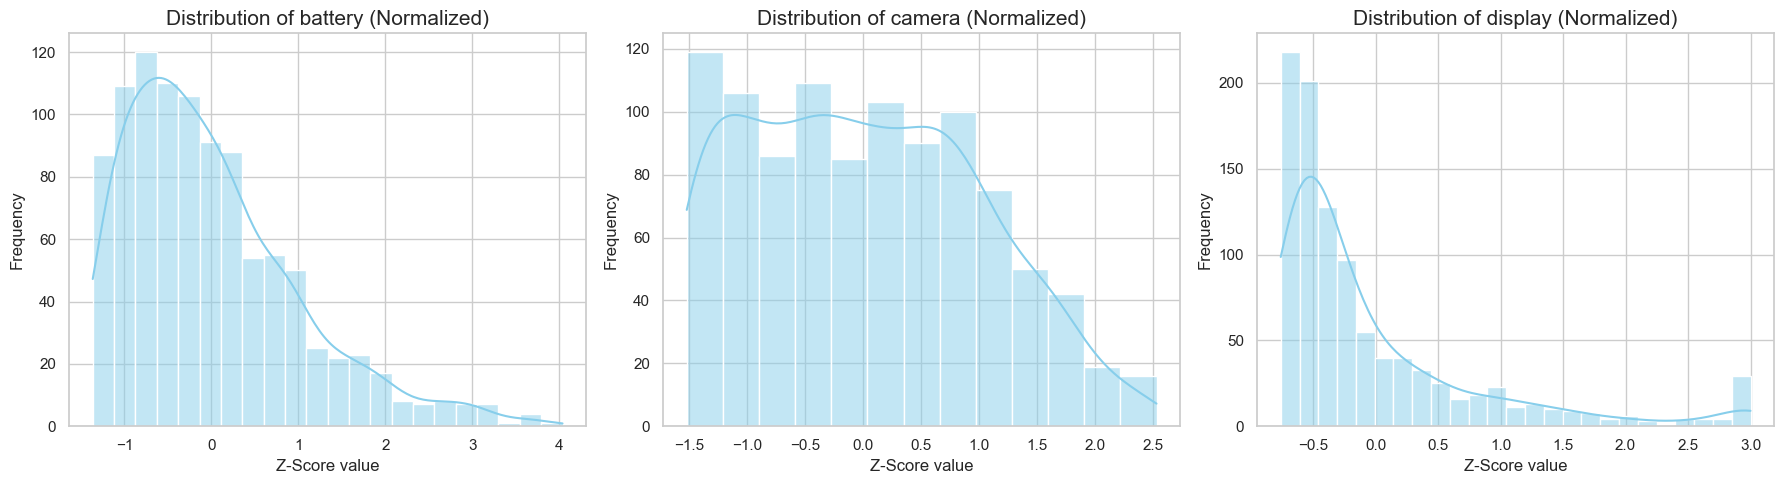

In [75]:
#5. 정규화
    #분류에서 바로 정규화가 가능하다
    #sklearn의 Standardscaler를 사용해 바로 정규화 가능

num_cols = [
    'battery',
    'clock_speed',
    'camera',
    'display',
    'int_memory',
    'mobile_wt',
    'n_cores',
    'ram'
]

for col in num_cols:
    mean = df[col].mean()
    std = df[col].std()
    df[col] = (df[col] - mean) / std

#display 이상치 제어
    #z-score가 3보다 큰 값을 이상치로 간주하고 3으로 강제변경
df['display'] = df['display'].clip(upper=3)

#시각화(추후 학습, 편의위해 사용)
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
target_cols = ['battery', 'camera', 'display']

for i,col in enumerate(target_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'Distribution of {col} (Normalized)', fontsize=15)
    axes[i].set_xlabel('Z-Score value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


#### Display데이터 쏠림 현상제어
1. 극단적으로 쏠림 -> log변환으로 완화시킴
2. Z-score가 7까지 있는등 이상치 존재 -> 3이상은 3으로 변환해 이상치 처리

In [76]:
#6. 분류 진행

#6-1. 가격범위 설정
    #train파일에 price_range이 있다는걸 모르고,,, 제외해서 직접 만들기
    # 가격 설정 (0: 저가형, 1: 중저가형, 2: 중고가형, 3: 고가형)
    # 사용되는 성능 : battery, ram, camera, display, int_memory, n_cores

df['price_score'] = (
    df['battery']+
    df['ram']*3+
    df['camera']+
    df['display']+
    df['int_memory']+
    df['n_cores']
)

df['price_range'] = pd.qcut(df['price_score'], q=4, labels=[0, 1, 2, 3])
print("### 가격 범위별 데이터 분포 ### \n")
print(df['price_range'].value_counts())


#6-2. 로지스틱 회귀 모델링

#6-2-1. 데이터 분리
X = df[['battery', 'ram', 'camera', 'display', 'int_memory', 'n_cores']]
Y = df['price_range']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#6-2-2. 모델 학습
model = LogisticRegression()
model.fit(X_train, Y_train)

#6-2-3. 예측 및 평가
Y_pred = model.predict(X_test)
print("\n=== 로지스틱 회귀 분석 결과 ===")
print("정확도:", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

### 가격 범위별 데이터 분포 ### 

price_range
0    250
1    250
2    250
3    250
Name: count, dtype: int64

=== 로지스틱 회귀 분석 결과 ===
정확도: 0.94
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        50
           1       0.86      0.98      0.92        50
           2       0.92      0.94      0.93        50
           3       1.00      0.94      0.97        50

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

